# Problem Set 6: Trees and Forests


## Part 1: Exploring the Titanic

Your mission for this problem set is to use your knowledge of supervised machine learning to try to predict which passengers aboard the Titanic were most likely to survive. The prompts for this part of the problem set are deliberately vague - the goal is to leave it up to you how to structure (most of) your analysis.

To get started, read about the prediction problem on [Kaggle](https://www.kaggle.com/c/titanic). Then, download the data [here](https://www.kaggle.com/c/titanic/data) - you'll at the very least need the train.csv data.

### 1.1 Exploratory data analysis

Create 2-3 figures and tables that help give you a feel for the data. Make sure to at least check the data type of each variable, to understand which variables have missing observations, and to understand the distribution of each variable (and determine whether the variables should be normalized or not). Are any of the potential predictor variables (i.e., anything except for survival) collinear or highly correlated? 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from  sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [185]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

We use one hot encoding for the values of Sex, where male = 1, and female = 0. Similarly, for the Embarked column, we change S = 1, C = 2, Q = 3.

In [186]:
train['Sex'] = train['Sex'].replace({"male": 1, "female": 0})
train['Embarked'] = train['Embarked'].replace({"S": 1, "C": 2, "Q":3})

In [6]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,2.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,1.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,1.0
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,W./C. 6607,23.4500,NaN,1.0
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,2.0


Because the variables are all in relatively the same scale, we do not need to normalize the features. From the correlation matrix below, we see that Fare and PClass, Sex and Survived, Fare and Parch, Fare and Survived are all relatively highly correlated

In [7]:
train.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.036847,-0.057527,-0.001652,0.012658,-0.030555
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.077221,-0.035322,0.081629,0.257307,0.108669
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.369226,0.083081,0.018443,-0.549500,0.043835
Sex,0.042939,-0.543351,0.131900,1.000000,0.093254,-0.114631,-0.245489,-0.182333,-0.118593
Age,0.036847,-0.077221,-0.369226,0.093254,1.000000,-0.308247,-0.189119,0.096067,0.012186
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.308247,1.000000,0.414838,0.159651,-0.060606
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.189119,0.414838,1.000000,0.216225,-0.079320
Fare,0.012658,0.257307,-0.549500,-0.182333,0.096067,0.159651,0.216225,1.000000,0.063462
Embarked,-0.030555,0.108669,0.043835,-0.118593,0.012186,-0.060606,-0.079320,0.063462,1.000000


One of the figures we include is a table below that has key statistic values for each variable. The other figure below are histograms showing the age distribution and survival distribution.

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,1.362205
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.636157
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000


/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


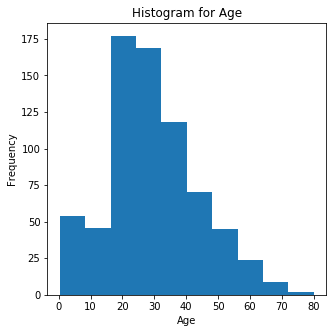

In [9]:
fig, ax = plt.subplots(figsize=(5,5))

ax.hist(train['Age'])
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
ax.set_title('Histogram for Age')

plt.show(fig)

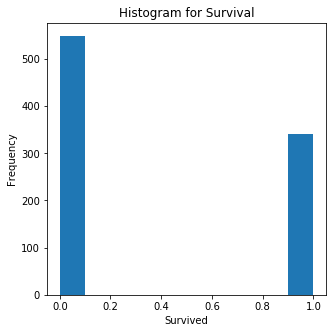

In [10]:
fig, ax = plt.subplots(figsize=(5,5))

ax.hist(train['Survived'])
ax.set_xlabel('Survived')
ax.set_ylabel('Frequency')
ax.set_title('Histogram for Survival')

plt.show(fig)

### 1.2 Correlates of survival

Use whatever methods you can think of to try and figure out what factors seem to determine whether or not a person would survive the sinking of the Titanic. What do you conclude?

We find the p value for every feature to see which feature is significant.

In [11]:
features = ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']

survived_1 = train[train['Survived']==1].dropna()
survived_0 = train[train['Survived']==0].dropna()

p_values = np.zeros(len(features))

for i in range(len(features)):
    t_statistic, p_val = stats.ttest_ind(survived_0[features[i]],survived_1[features[i]],equal_var=False)
    
    p_values[i] = p_val
    
df_pval = pd.DataFrame({'Feature':features,'p_val':p_values,})
df_pval

,Feature,p_val
0,PassengerId,4.936901e-02
1,Pclass,6.649011e-01
2,Sex,3.319798e-18
3,Age,7.481344e-04
4,SibSp,1.422190e-01
5,Parch,7.603907e-01
6,Fare,4.673085e-02
7,Embarked,2.616163e-01


In [12]:
sig_features = []
for i in range(len(df_pval)):
    if df_pval.iloc[i,1] < 0.05:
        sig_features.append(df_pval.iloc[i,0])

print("Significant features for survival of titanic where p value is < 0.05 are:",sig_features)

Significant features for survival of titanic where p value is < 0.05 are: ['PassengerId', 'Sex', 'Age', 'Fare']


We ran a t_test on two populations, the population that survived, and the population that did not. From this, we found the P-values for each of the features. If the p_value is less than 0.05, then it is significant. Of all the features, we found the significant features to be PassengerId, Sex, Age and Fare.

## Part 2: Decision Trees
### 2.1 Decision Tree
Using the basic [Decision Tree](http://scikit-learn.org/stable/modules/tree.html#tree) library in sklearn, fit a model to predict titanic survival. Make sure you come up with an appropriate way of handling each of the input variables before feeding them in to the decision tree. You can use the [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) method to implement 10-fold cross-validation.

For this any the following problems, you should set aside some of your training data as held-out test data, prior to cross-validation. Report the average training and testing accuracy across your 10 folds, and show a diagram of the tree (at least the first three levels). Finally, select the best-performing decision tree (i.e., the one that achieved the highest cross-validated performance) and report the performance of the fitted model on the held-out test data -- how does it compare to the cross-validated accuracy?


In [13]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score

In [187]:
# Get rid of Name, ticket, cabin columns
x = train.drop(columns=['Name','Ticket','Cabin'])

In [188]:
x.dropna(inplace=True)
x.reset_index(drop=True, inplace=True)

In [189]:
y = pd.DataFrame({"Survived":x['Survived']})
y = y.replace({0: -1})
x = x.drop(columns=['Survived'])

In [190]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0) 

In [191]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)

train = []
test = []
for train_index, test_index in kf.split(X_train):
    train.append(train_index)
    test.append(test_index)

train_accuracy = []
test_accuracy = []


In [192]:
for i in range(10):
    
    model = tree.DecisionTreeClassifier()
    model = model.fit(X_train.iloc[train[i],:], y_train.iloc[train[i],:])
    
    predict_train = model.predict(X_train.iloc[train[i],:])
    predict_test = model.predict(X_train.iloc[test[i],:])
    
    train_accuracy.append(accuracy_score(y_train.iloc[train[i],:], predict_train))
    test_accuracy.append(accuracy_score(y_train.iloc[test[i],:], predict_test))

In [193]:
print("10 fold cross validation Training accuracy is:")
print("")
print(train_accuracy)
print("")
print("Mean training accuracy is:",np.mean(train_accuracy))
print("")
print("10 fold cross validation Testing accuracy is:")
print("")
print(test_accuracy)
print("")
print("Mean testing accuracy is:",np.mean(test_accuracy))

10 fold cross validation Training accuracy is:

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Mean training accuracy is: 1.0

10 fold cross validation Testing accuracy is:

[0.7368421052631579, 0.6666666666666666, 0.7192982456140351, 0.7017543859649122, 0.7017543859649122, 0.7719298245614035, 0.7368421052631579, 0.7543859649122807, 0.7543859649122807, 0.7142857142857143]

Mean testing accuracy is: 0.7258145363408521


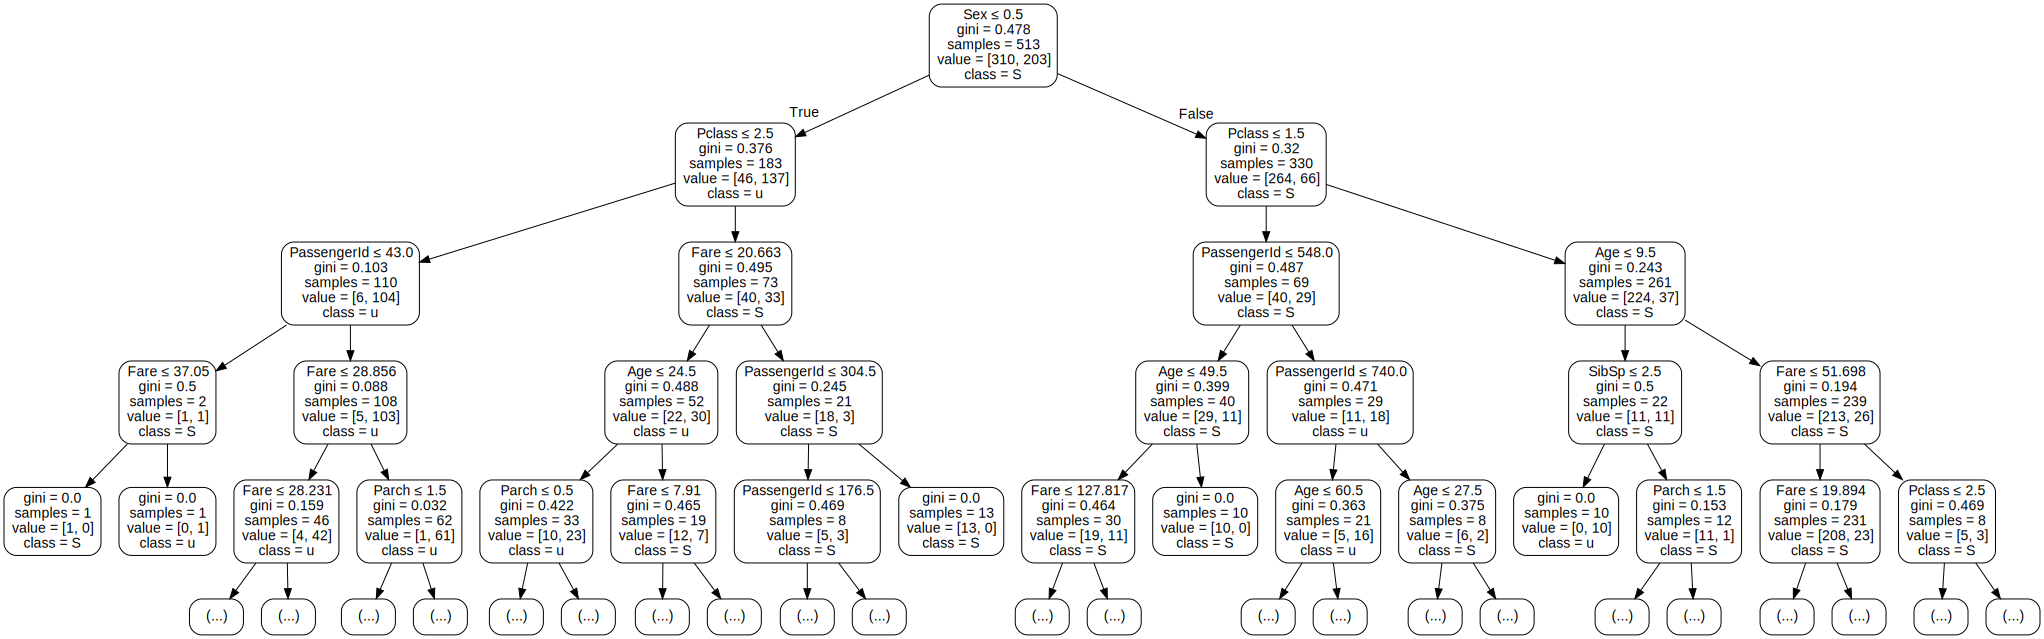

In [194]:
import graphviz
dot_data = tree.export_graphviz(model, out_file=None,
                                feature_names=X_train.columns,class_names='Survived',
                                rounded=True, max_depth = 4, special_characters=True)
graph = graphviz.Source(dot_data)
graph

The training and testing accuracy across the 10-folds are shown above, as well as their means. As we can see, the training accuracy all performed with 100%. Of the testing accuracy, our highest accuracy is with a percentage of 76.79%, which is the last entry of the cross validation. We then report the performance of the fitted model on the held-out test data.

In [195]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train.iloc[train[9],:], y_train.iloc[train[9],:])

heldout_test_accuracy = []
predict_test = model.predict(X_test)
heldout_test_accuracy.append(accuracy_score(y_test, predict_test))

print("Accuracy of fitted model on held out test data:",heldout_test_accuracy)

Accuracy of fitted model on held out test data: [0.7552447552447552]


The accuracy of our fitted model on the held out test data is actually higher than the than the highest cross validated accuracy, where 0.76792 > 0.7679. This is really interesting because our model is trained on the training data, and performed better on the testing data. 

### 2.2 Features

Use all of the data (minus the held-out data) to re-fit a single decision tree with max_depth = 4 (i.e., no cross-validation). Show the tree diagram and also plot the feature importances. What do you observe?

In [23]:
model = tree.DecisionTreeClassifier(max_depth=4,random_state=0)
model = model.fit(X_train, y_train)

predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

train_accuracy = accuracy_score(y_train, predict_train)
test_accuracy = accuracy_score(y_test, predict_test)

print("Training data accuracy:",train_accuracy)
print("Testing data accuracy:",test_accuracy)

Training data accuracy: 0.8453427065026362
Testing data accuracy: 0.7902097902097902


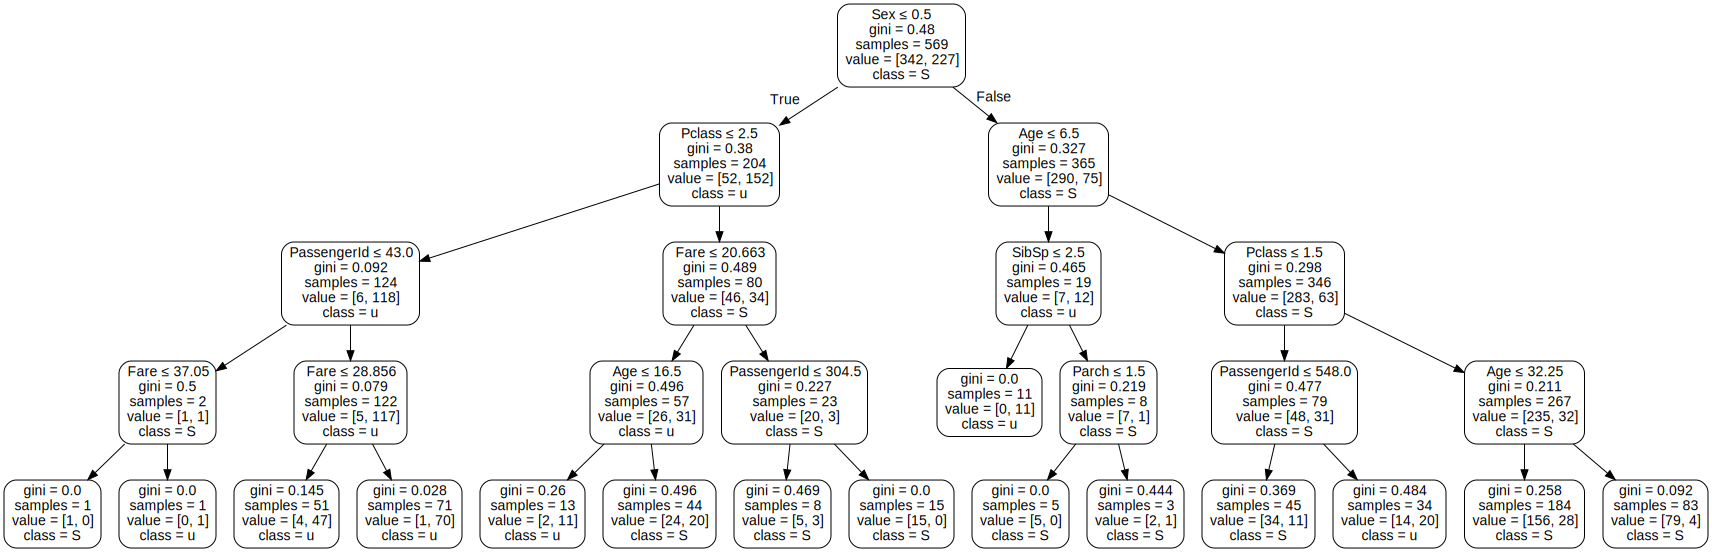

In [24]:
dot_data = tree.export_graphviz(model, out_file=None,
                                feature_names=X_train.columns,class_names='Survived',
                                rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

Feature importances

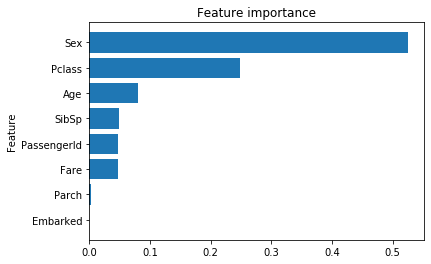

In [25]:
features = ["Passengerld","Pclass","Sex","Age",'SibSp',"Parch","Fare","Embarked"]
importances = model.feature_importances_
idx = np.argsort(importances)
plt.title("Feature importance")
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.ylabel("Feature")
plt.show()

Looking at the decision tree, we see that the root of the tree is the 'Sex' variable. This means that having the root as 'Sex' will lead to the lowest cost for the tree. Looking at the feature importance graph, we see that the variable "Sex" has the highest probability, followed by "Pclass" and "Age". Gini index or Gini impurity measures the degree or probability of a particular variable being wrongly classified when it is randomly chosen, and from this graph, it shows that "Sex" has the highest probability.

### 2.3 Tree Tuning
The built-in algorithm you are using has several parameters which you can tune. Using cross-validation, show how the choice of these parameters affects performance.

First, show how max_depth affects train and test accuracy. On a single axis, plot train and test accuracy as a function of max_depth. Use a red line to show test accuracy and a blue line to show train accuracy. Do not use your held-out test data.

Second, show how test accuracy relates to both max_depth and min_samples_leaf. Specifically, create a 3-D plot where the x-axis is max_depth, the y-axis is min_samples_leaf, and the z-axis shows accuracy. What combination of max_depth and min-samples_leaf achieves the highest accuracy? How sensitive are the results to these two parameters?

In [174]:
X_train

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
140,141,3,0,29.699118,0,2,15.2458,2.0
439,440,2,1,31.000000,0,0,10.5000,1.0
817,818,2,1,31.000000,1,1,37.0042,2.0
378,379,3,1,20.000000,0,0,4.0125,2.0
491,492,3,1,21.000000,0,0,7.2500,1.0
...,...,...,...,...,...,...,...,...
835,836,1,0,39.000000,1,1,83.1583,2.0
192,193,3,0,19.000000,1,0,7.8542,1.0
629,630,3,1,29.699118,0,0,7.7333,3.0
559,560,3,0,36.000000,1,0,17.4000,1.0


In [264]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0) 

In [27]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)

train = []
test = []
for train_index, test_index in kf.split(X_train):
    train.append(train_index)
    test.append(test_index)

train_depth_accuracy = []
test_depth_accuracy = []

# we iterate through depths from 1 to 20
for i in range(1,20):
    
    train_accuracy = []
    test_accuracy = []
    
    for j in range(10):
    
        model = tree.DecisionTreeClassifier(max_depth=i,random_state=0)
        model = model.fit(X_train.iloc[train[j],:], y_train.iloc[train[j],:])
    
        predict_train = model.predict(X_train.iloc[train[j],:])
        predict_test = model.predict(X_train.iloc[test[j],:])
    
        train_accuracy.append(accuracy_score(y_train.iloc[train[j],:], predict_train))
        test_accuracy.append(accuracy_score(y_train.iloc[test[j],:], predict_test))
    
    train_depth_accuracy.append(np.mean(train_accuracy))
    test_depth_accuracy.append(np.mean(test_accuracy))

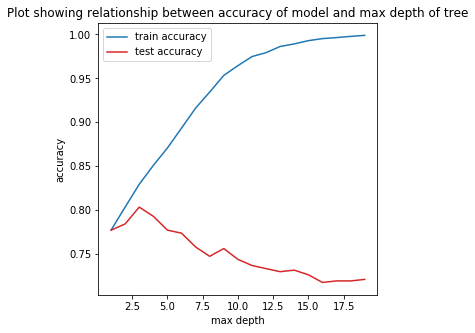

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(np.arange(1,20),train_depth_accuracy,c='C0',label='train accuracy')
ax.plot(np.arange(1,20),test_depth_accuracy,c='C3',label='test accuracy')

ax.set_xlabel('max depth')
ax.set_ylabel('accuracy')
ax.set_title('Plot showing relationship between accuracy of model and max depth of tree')
ax.legend()

In [29]:
np.max(train_depth_accuracy)

0.9990249604044834

Second, show how test accuracy relates to both max_depth and min_samples_leaf. Specifically, create a 3-D plot where the x-axis is max_depth, the y-axis is min_samples_leaf, and the z-axis shows accuracy. What combination of max_depth and min-samples_leaf achieves the highest accuracy? How sensitive are the results to these two parameters?

In [30]:
depths = np.arange(1,20)
min_leaf = np.arange(2,30)

In [31]:
train_depth_leaf_accuracy = np.zeros((len(depths),len(min_leaf)))
test_depth_leaf_accuracy = np.zeros((len(depths),len(min_leaf)))

In [32]:
# we iterate through depths from 1 to 20
for i in range(len(depths)):
    
    # iterate through min_sample_leaf from 2 to 30
    for j in range(len(min_leaf)):
        
        train_accuracy = []
        test_accuracy = []
        
        for k in range(10):
    
            model = tree.DecisionTreeClassifier(max_depth=depths[i],min_samples_leaf=min_leaf[j],random_state=0)
            model = model.fit(X_train.iloc[train[k],:], y_train.iloc[train[k],:])
    
            predict_train = model.predict(X_train.iloc[train[k],:])
            predict_test = model.predict(X_train.iloc[test[k],:])
    
            train_accuracy.append(accuracy_score(y_train.iloc[train[k],:], predict_train))
            test_accuracy.append(accuracy_score(y_train.iloc[test[k],:], predict_test))
    
        train_depth_leaf_accuracy[i][j]=np.mean(train_accuracy)
        test_depth_leaf_accuracy[i][j]=np.mean(test_accuracy)

In [33]:
# Find max index for train accuracy

max_train = np.max(train_depth_leaf_accuracy)
train_idx = [0,0]
for i in range(len(depths)):
    for j in range(len(min_leaf)):
        if train_depth_leaf_accuracy[i][j] == max_train:
            train_idx = [depths[i],min_leaf[j]]

# Find max index for test accuracy

max_test = np.max(test_depth_leaf_accuracy)
test_idx = [0,0]
for i in range(len(depths)):
    for j in range(len(min_leaf)):
        if test_depth_leaf_accuracy[i][j] == max_test:
            test_idx = [depths[i],min_leaf[j]]

print("A max depth value of {} and min_sample_leaf value of {} leads to the highest training accuracy of {}".format(train_idx[0],train_idx[1],max_train))     
print("")
print("A max depth value of {} and min_sample_leaf value of {} leads to the highest testing accuracy of {}".format(test_idx[0],test_idx[1],max_test))                

A max depth value of 19 and min_sample_leaf value of 2 leads to the highest training accuracy of 0.9396606207358674

A max depth value of 3 and min_sample_leaf value of 10 leads to the highest testing accuracy of 0.8065789473684208


In [199]:
# Accuracy on held out testing set

decision_tree_model = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=10,random_state=0)
decision_tree_model = decision_tree_model.fit(X_train, y_train)
predict_tree_model = model.predict(X_test)
decision_tree_accuracy = accuracy_score(y_test, predict_tree_model)
print("Accuracy on the held-out testing set is {}".format(decision_tree_accuracy))  

Accuracy on the held-out testing set is 0.7552447552447552


In [44]:
train_depth_leaf_accuracy

array([[0.77680045, 0.77680045, 0.77680045, 0.77680045, 0.77680045,
        0.77680045, 0.77680045, 0.77680045, 0.77680045, 0.77680045,
        0.77680045, 0.77680045, 0.77680045, 0.77680045, 0.77680045,
        0.77680045, 0.77680045, 0.77680045, 0.77680045, 0.77680045,
        0.77680045, 0.77680045, 0.77680045, 0.77680045, 0.77680045,
        0.77680045, 0.77680045, 0.77680045],
       [0.80316498, 0.80316498, 0.80316498, 0.80316498, 0.80316498,
        0.80316498, 0.80316498, 0.80316498, 0.80316498, 0.80316498,
        0.80316498, 0.80316498, 0.80316498, 0.80316498, 0.80316498,
        0.80316498, 0.80257904, 0.80257904, 0.80238373, 0.80160248,
        0.80160248, 0.80160248, 0.80160248, 0.80160248, 0.80140716,
        0.80121185, 0.80003998, 0.79925873],
       [0.82894052, 0.82894052, 0.82894052, 0.82894052, 0.82894052,
        0.8287452 , 0.82815927, 0.82679208, 0.8256202 , 0.8256202 ,
        0.8256202 , 0.82542489, 0.82327645, 0.8193702 , 0.8193702 ,
        0.81839364, 0.8176

Text(0.5, 0.92, 'Testing Accuracy across max_depth and min_samples_leaf')

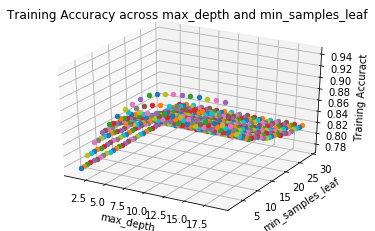

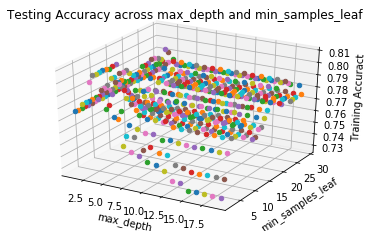

In [47]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

train_3d = plt.figure().gca(projection='3d')
for i in range(len(depths)):
    for j in range(len(min_leaf)):
        train_3d.scatter(depths[i], min_leaf[j], train_depth_leaf_accuracy[i][j])
        
train_3d.set_xlabel('max_depth')
train_3d.set_ylabel('min_samples_leaf')
train_3d.set_zlabel('Training Accuract')
train_3d.set_title('Training Accuracy across max_depth and min_samples_leaf')


test_3d = plt.figure().gca(projection='3d')
for i in range(len(depths)):
    for j in range(len(min_leaf)):
        test_3d.scatter(depths[i], min_leaf[j], test_depth_leaf_accuracy[i][j])
        
test_3d.set_xlabel('max_depth')
test_3d.set_ylabel('min_samples_leaf')
test_3d.set_zlabel('Training Accuract')
test_3d.set_title('Testing Accuracy across max_depth and min_samples_leaf')


Looking at the first plot, we clearly see that as the max_depth of the tree increases the training accuracy increases. However, as the depth of the tree increases, the test accuracy first increases, and then decreases. This makes sense because the higher the depth in the tree, the higher the variance of the model, and thus it would perform worse on the test accuracy. For the 3D plot, we see that a max depth value of 19 and min_sample_leaf value of 2 leads to the highest training accuracy of 0.9396606207358674, and a max depth value of 3 and min_sample_leaf value of 10 leads to the highest testing accuracy of 0.8065789473684208. From looking at the plots above, we see that the results are very sensitive for the parameters. For example, if min_samples_leaf is low, we see that the accuracy becomes low.

### 2.4 Support Vector Machines, for comparison

Now use an [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) to predict survival, using  the default value for the constant penalization (C=1).  Report your accuracy on the test and train sets. 

Use cross-validation to determine a possibly better choice for C. Note that regularization is inversely proportional to the value of C in sklearn, i.e. the higher value you choose for C the less you regularize. 
    
    
* How does the test performance with SVM for your best choice of C compare to the decision tree performance?


In [59]:
from sklearn import svm

svm_model_1 = svm.SVC(C=1) 

svm_model_1.fit(X_train, y_train)

svm1_pred_train = svm_model_1.predict(X_train)
svm1_pred_test = svm_model_1.predict(X_test)

svm1_train_accuracy = accuracy_score(y_train, svm1_pred_train)
svm1_test_accuracy = accuracy_score(y_test, svm1_pred_test)

print("Training accuacy of svm with C=1 is {}".format(svm1_train_accuracy))     
print("")
print("Testing accuacy of svm with C=1 is {}".format(svm1_test_accuracy))    
              

Training accuacy of svm with C=1 is 1.0

Testing accuacy of svm with C=1 is 0.5734265734265734


/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [265]:
# Use cross validation to determine a better choice for C. 
# We use values of C from 1 to 10:

C_val = np.arange(1,10)

svm_train_accuacy_2 = []
svm_test_accuacy_2 = []

for i in range(len(C_val)):
    
    svm_2 = svm.SVC(C=C_val[i]) 
    train_accuacy = []
    test_accuacy = []
    
    for j in range(10):
        
        svm_2.fit(X_train.iloc[train[j],:], y_train.iloc[train[j],:])
        svm_2_predict_train = svm_2.predict(X_train.iloc[train[j],:])
        svm_2_predict_test = svm_2.predict(X_train.iloc[test[j],:])
    
        train_accuracy.append(accuracy_score(y_train.iloc[train[j],:], svm_2_predict_train))
        test_accuracy.append(accuracy_score(y_train.iloc[test[j],:], svm_2_predict_test))
    
    svm_train_accuacy_2.append(np.mean(train_accuracy))
    svm_test_accuacy_2.append(np.mean(test_accuracy))

max_C_idx = np.argmax(svm_test_accuacy_2)

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

In [266]:
print("Mean CV Training accuracy of svm with C values ranging fom 1 to 10 is:") 
print(svm_train_accuacy_2)
print("")
print("Mean CV Testing accuracy of svm with C values ranging fom 1 to 10 is:") 
print(svm_test_accuacy_2)
print("")
print("A C value of {} leads to the highest CV testing accuracy of {}".format(max_C_idx+1,svm_test_accuacy_2[max_C_idx]))

Mean CV Training accuracy of svm with C values ranging fom 1 to 10 is:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Mean CV Testing accuracy of svm with C values ranging fom 1 to 10 is:
[0.6625313283208021, 0.6390977443609022, 0.6273809523809524, 0.6203508771929824, 0.6156641604010024, 0.6123165055495882, 0.6098057644110275, 0.6078529657477025, 0.6062907268170425]

A C value of 1 leads to the highest CV testing accuracy of 0.6625313283208021


In [270]:
# Accuracy on held out testing data 

svm_model_test = svm.SVC(C=1) 
svm_model_test = svm_model_test.fit(X_train, y_train)
svm_model_test_predict = svm_model_test.predict(X_test)
svm_model_test_accuracy = accuracy_score(y_test, svm_model_test_predict)

print("Accuracy on the held-out testing set is {}".format(svm_model_test_accuracy))  

Accuracy on the held-out testing set is 0.5734265734265734


/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


From the code above, we find that a C value of 9 leads to the highest CV testing accuacy of 0.8132584751352063. Our decision tree model with a max depth value of 3 and min_sample_leaf value of 10 has a testing accuracy of 0.8065789473684208. Thus we see that our SVM model slightly performs better than our decision tree model.

### 2.5 Missing Data
Have you been paying close attention to your features? If not, now is a good time to start. Perform analysis that allows you to answer the following questions:
* Do any of your features have missing data? If so, which ones? What percent of observations have missing data?
* What happens to observations with missing data when you run the decision tree and SVM models above?
* Use one of the methods we discussed in class to impute missing values
* Rerun your decision tree and SVM on the new dataset with imputed missing values. What do you notice?

In [120]:
# Do any of your features have missing data? If so, which ones? What percent of observations have missing data?

original_data = pd.read_csv("train.csv")
original_data['Sex'] = original_data['Sex'].replace({"male": 1, "female": 0})
original_data['Embarked'] = original_data['Embarked'].replace({"S": 1, "C": 2, "Q":3})

Survival = pd.DataFrame({"Survived":original_data['Survived']})
Survival = Survival.replace({0: -1})

original_data = original_data.drop(columns=['Survived'])

np.sum(original_data.isnull())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [121]:
np.sum(np.sum(original_data.isnull()))/(len(original_data)*11)

0.08835833078257321

There are three features that have missing data: Age, Cabin and Embarked. From the above calculation, we find that 8.8% of observations have missing data.

In [122]:
# We have to get rid of the Name, Ticket and Cabin columns because the values are strings. Even though the Cabin feature makes up most of the missing values,
# we will still have missing values from Age and Embarked. 

original_data = original_data.drop(columns=['Name','Ticket','Cabin'])

In [ ]:
#What happens to observations with missing data when you run the decision tree and SVM models above?

# Decision tree model

tree_model = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=10,random_state=0)
tree_model = tree_model.fit(original_data,Survival)
    
predict_test_tree = tree_model.predict(original_data)
tree_accuracy = accuracy_score(Survival,predict_test_tree)

# SVM model

svm_model = svm.SVC(C=9) 
        
svm_model.fit(original_data,Survival)
predict_test_svm = svm_model.predict(original_data)

svm_accuracy = accuracy_score(Survival,predict_test_svm)

When our observations have missing values, and we run the decision tree and SVM models, we run into the following error. "Input contains NaN, infinity or a value too large for dtype('float32')". Thus, we are not able to fit a model when there is missing data in the observations.

In [168]:
original_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,1,22.000000,1,0,7.2500,1.0
1,2,1,0,38.000000,1,0,71.2833,2.0
2,3,3,0,26.000000,0,0,7.9250,1.0
3,4,1,0,35.000000,1,0,53.1000,1.0
4,5,3,1,35.000000,0,0,8.0500,1.0
...,...,...,...,...,...,...,...,...
886,887,2,1,27.000000,0,0,13.0000,1.0
887,888,1,0,19.000000,0,0,30.0000,1.0
888,889,3,0,29.699118,1,2,23.4500,1.0
889,890,1,1,26.000000,0,0,30.0000,2.0


In [169]:
# Use one of the methods we discussed in class to impute missing values

# We impute missing values in the Age and Embarked columns. We do this by imputing the mean value of all the observations for that feature.

mean_Age = np.nanmean(original_data['Age'])
for i in range(len(original_data)):
    if ~np.isfinite(original_data.iloc[i,3]):
        original_data.iloc[i,3] = mean_Age
        
mean_Embarked = np.nanmean(original_data['Embarked'])
for i in range(len(original_data)):
    if ~np.isfinite(original_data.iloc[i,7]):
        original_data.iloc[i,7] = mean_Embarked

original_data.isnull().any()

PassengerId    False
Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Embarked       False
dtype: bool

In [170]:
X_train, X_test, y_train, y_test = train_test_split(original_data, Survival, test_size=0.2, random_state=0)

train = []
test = []
for train_index, test_index in kf.split(X_train):
    train.append(train_index)
    test.append(test_index)

In [171]:
# Rerun your decision tree and SVM on the new dataset with imputed missing values. What do you notice?

# Decision tree model

tree_model = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=10,random_state=0)

tree_cv_accuracy = []
for i in range(10):
    tree_model = tree_model.fit(X_train.iloc[train[i],:], y_train.iloc[train[i],:])
    tree_predict_cv = tree_model.predict(X_train.iloc[test[i],:])
    tree_cv_accuracy.append(accuracy_score(y_train.iloc[test[i],:], tree_predict_cv))
mean_tree_cv_accuracy = np.mean(tree_cv_accuracy)   
    
tree_predict_test = tree_model.predict(X_test)
tree_test_accuracy = accuracy_score(y_test,tree_predict_test)

# SVM model

svm_model = svm.SVC(C=9) 
svm_cv_accuracy = []

for i in range(10):
    svm_model = svm_model.fit(X_train.iloc[train[i],:], y_train.iloc[train[i],:])
    svm_predict_cv = svm_model.predict(X_train.iloc[test[i],:])
    svm_cv_accuracy.append(accuracy_score(y_train.iloc[test[i],:], svm_predict_cv))
mean_svm_cv_accuracy = np.mean(svm_cv_accuracy)   
        
svm_predict_test = svm_model.predict(X_test)
svm_test_accuracy = accuracy_score(y_test,svm_predict_test)

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

In [172]:
print("Mean Validation accuracy of CV decision tree model :") 
print(mean_tree_cv_accuracy)
print("")
print("Testing accuracy of decision tree model:") 
print(tree_test_accuracy)
print("")
print("Mean Validation accuracy of CV SVM model :") 
print(mean_svm_cv_accuracy)
print("")
print("Testing accuracy of SVM model:") 
print(svm_test_accuracy)
print("")

Mean Validation accuracy of CV decision tree model :
0.8119327073552427

Testing accuracy of decision tree model:
0.8379888268156425

Mean Validation accuracy of CV SVM model :
0.6026017214397497

Testing accuracy of SVM model:
0.6089385474860335



Looking at the above accuracy values, we see that the imputed SVM model has a higher held out testing accuracy of 0.6089385474860335 compared to 0.5734265734265734. The accuracy of the imputed CV SVM model has a lower accuracy of 0.6026017214397497 compared to the non imputed data with an accuracy of 0.6625313283208021. For the decision tree model, the accuracy for both the held out testing data, and validation accuracy from CV is both higher than the decision tree model for the non imputed data. 0.8379888268156425 > 0.7552447552447552 and 0.8119327073552427 >   0.8065789473684208

## Part 3: Forests

### 3.1: Random Forest
Use the [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to predict survival on the titanic. Use cross-validation on the training data to choose the best hyper-parameters. 
* What hyperparameters did you select with cross-validation?
* How does the cross-validated performance (average across validation folds) compare to the test performance (using the top-performing, fitted model selected through cross-validation)?
* How does the RF performance compare to the decision tree and SVM?
* Create a plot that shows how cross-validated performance (y-axis) relates to the number of trees in the forest (x-axis).

In [213]:
from sklearn.ensemble import RandomForestClassifier

In [214]:
# For the non_imputed data

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0) 

In [222]:
num_trees = np.arange(1,50)

rf_CV_accuracy = []

for i in range(len(num_trees)):
    rf_model = RandomForestClassifier(n_estimators = num_trees[i], random_state=0) 

    rf_accuracy = [] 
    for j in range(10):
        
        rf_model.fit(X_train.iloc[train[j],:], y_train.iloc[train[j],:])
        rf_model_predict = rf_model.predict(X_train.iloc[test[j],:])
        
        rf_accuracy.append(accuracy_score(y_train.iloc[test[j],:], rf_model_predict))
    
    rf_CV_accuracy.append(np.mean(rf_accuracy))
    
max_indx_rf = np.argmax(rf_CV_accuracy)

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

In [223]:
print("Mean CV accuracy of random forest with num_trees ranging fom 1 to 49 is:") 
print(rf_CV_accuracy)
print("")
print("A num_trees value of {} leads to the highest CV testing accuracy of {}".format(max_indx_rf+1,rf_CV_accuracy[max_indx_rf]))

Mean CV accuracy of random forest with num_trees ranging fom 1 to 49 is:
[0.7381892230576441, 0.7611215538847118, 0.7521929824561404, 0.7732456140350876, 0.7644423558897243, 0.7786340852130326, 0.7803571428571429, 0.7856516290726817, 0.7855889724310777, 0.7926065162907268, 0.7908208020050125, 0.7961466165413534, 0.7908521303258145, 0.8014097744360903, 0.7978696741854636, 0.7979010025062656, 0.7979010025062656, 0.8049498746867169, 0.8101817042606516, 0.811967418546366, 0.8084586466165413, 0.8031954887218046, 0.8049498746867167, 0.8014411027568922, 0.794392230576441, 0.794392230576441, 0.7961466165413534, 0.794423558897243, 0.7926065162907268, 0.7996553884711779, 0.7978383458646616, 0.8014097744360902, 0.7996553884711779, 0.8031641604010025, 0.7996240601503759, 0.806704260651629, 0.794360902255639, 0.7996867167919799, 0.7908834586466165, 0.7961779448621553, 0.7890977443609022, 0.7891290726817042, 0.7943922305764411, 0.7891290726817042, 0.7961466165413533, 0.7926378446115289, 0.7908521303

In [225]:
# Held out testing accuracy

rf_model_test = RandomForestClassifier(n_estimators = 20, random_state=0) 
rf_model_test.fit(X_train,y_train)
rf_model_test_predict = rf_model_test.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, rf_model_test_predict)

print("Held out testing accuracy of random forest with num_trees = 20 is ") 
print(rf_test_accuracy)

Held out testing accuracy of random forest with num_trees = 20 is 
0.7832167832167832


/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [228]:
# Compute CV accuracy and held out test data accuracy for the imputed data set.

X_train, X_test, y_train, y_test = train_test_split(original_data, Survival, test_size=0.2,random_state=0) 

imp_rf_model = RandomForestClassifier(n_estimators = 20, random_state=0)

imp_rf_CV_accuracy = []

for i in range(10):
        
    imp_rf_model.fit(X_train.iloc[train[i],:], y_train.iloc[train[i],:])
    imp_rf_model_predict = imp_rf_model.predict(X_train.iloc[test[i],:])
    imp_rf_CV_accuracy.append(accuracy_score(y_train.iloc[test[i],:], imp_rf_model_predict))
    imp_rf_mean_CV_accuracy = np.mean(imp_rf_CV_accuracy)
    
# Compute held out test data accuracy


imp_rf_model.fit(X_train, y_train)
imp_rf_model_test_predict = imp_rf_model.predict(X_test)
imp_rf_test_accuracy = accuracy_score(y_test, imp_rf_model_test_predict)

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: D

In [229]:
print("Mean CV accuracy of random forest for imputed data is: ") 
print(imp_rf_mean_CV_accuracy)
print("Held-out testing accuracy of random forest for imputed data is: ") 
print(imp_rf_test_accuracy)

Mean CV accuracy of random forest for imputed data is: 
0.792700501253133
Held-out testing accuracy of random forest for imputed data is: 
0.8491620111731844


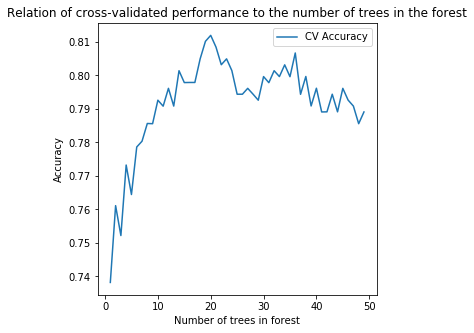

In [230]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(np.arange(1,50),rf_CV_accuracy,c='C0',label='CV Accuracy')

ax.set_xlabel('Number of trees in forest')
ax.set_ylabel('Accuracy')
ax.set_title('Relation of cross-validated performance to the number of trees in the forest')
ax.legend()

* What hyperparameters did you select with cross-validation?

The hyperparameter I selected for cross validation is the number of trees in the forest. I looked at the range between 1 to 49 trees. 

* How does the cross-validated performance (average across validation folds) compare to the test performance (using the top-performing, fitted model selected through cross-validation)?

The cross_validated model performed better with an accuracy of 0.811967418546366 compared to the test performance which had an accuracy of 0.7832167832167832.

* How does the RF performance compare to the decision tree and SVM?

The SVM model had an accuracy of 0.5734265734265734 on the held-out testing data and the decision tree model had an accuracy of 0.7552447552447552. Thus, the random forest model performed better than both models as it had an accuracy of 0.7832167832167832.

* Create a plot that shows how cross-validated performance (y-axis) relates to the number of trees in the forest (x-axis).

The plot above shows how cross-validated performance (y-axis) relates to the number of trees in the forest (x-axis).

### 3.2: Gradient Boosting

Use the [Gradient Boosting classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to predict survival on the Titanic. Tune your hyperparameters. 
* How does the GBM performance compare to the other models?
* Create a figure showing the feature importances in your final model (with properly tuned hyperparameters)


In [231]:
from sklearn.ensemble import GradientBoostingClassifier

In [247]:
# Start with the non imputed data

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0) 

num_estimators = np.arange(1,200) # the number of boosting stages to perform

GBC_CV_accuracy = []

for i in range(len(num_trees)):
    GBC_model = GradientBoostingClassifier(n_estimators = num_estimators[i], random_state=0) 

    GBC_accuracy = [] 
    for j in range(10):
        
        GBC_model.fit(X_train.iloc[train[j],:], y_train.iloc[train[j],:])
        GBC_model_predict = GBC_model.predict(X_train.iloc[test[j],:])
        
        GBC_accuracy.append(accuracy_score(y_train.iloc[test[j],:], GBC_model_predict))
    
    GBC_CV_accuracy.append(np.mean(GBC_accuracy))
    
max_indx_GBC = np.argmax(GBC_CV_accuracy)

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

In [250]:
print("Mean CV accuracy of Gradient Boosting Classifier with n_estimators ranging fom 1 to 200 is:") 
print(GBC_CV_accuracy)
print("")
print("A n_estimators value of {} leads to the highest CV testing accuracy of {}".format(max_indx_GBC+1,GBC_CV_accuracy[max_indx_GBC]))

Mean CV accuracy of Gradient Boosting Classifier with n_estimators ranging fom 1 to 200 is:
[0.6010025062656641, 0.7645989974937343, 0.7961779448621553, 0.79968671679198, 0.7979010025062657, 0.79968671679198, 0.7961779448621553, 0.7961779448621553, 0.7926691729323307, 0.7961779448621553, 0.8014411027568922, 0.7961779448621554, 0.7961466165413533, 0.7961466165413533, 0.7979323308270676, 0.7961466165413533, 0.8014097744360902, 0.799655388471178, 0.799655388471178, 0.8014097744360903, 0.799655388471178, 0.8049185463659148, 0.8031641604010025, 0.8066729323308272, 0.8066729323308272, 0.8066729323308272, 0.8102443609022556, 0.8137531328320803, 0.8137531328320803, 0.8119987468671679, 0.8137531328320803, 0.8137531328320803, 0.8119987468671679, 0.8102443609022556, 0.8119987468671679, 0.8155075187969925, 0.8172932330827068, 0.8155388471177945, 0.819047619047619, 0.8120300751879699, 0.8155388471177945, 0.8137844611528822, 0.8155388471177945, 0.8155388471177945, 0.8225563909774436, 0.8190476190476

In [251]:
# Held out testing accuracy

GBC_model_test = GradientBoostingClassifier(n_estimators = 45, random_state=0)  
GBC_model_test.fit(X_train,y_train)
GBC_model_test_predict = GBC_model_test.predict(X_test)
GBC_test_accuracy = accuracy_score(y_test, GBC_model_test_predict)

print("Held out testing accuracy of Gradient Boosting Classifier with n_estimators = 45 is ") 
print(GBC_test_accuracy)

Held out testing accuracy of Gradient Boosting Classifier with n_estimators = 45 is 
0.8251748251748252


/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [252]:
# Compute CV accuracy and held out test data accuracy for the imputed data set.

X_train, X_test, y_train, y_test = train_test_split(original_data, Survival, test_size=0.2,random_state=0) 

imp_GBC_model = GradientBoostingClassifier(n_estimators = 45, random_state=0)

imp_GBC_CV_accuracy = []

for i in range(10):
        
    imp_GBC_model.fit(X_train.iloc[train[i],:], y_train.iloc[train[i],:])
    imp_GBC_model_predict = imp_GBC_model.predict(X_train.iloc[test[i],:])
    imp_GBC_CV_accuracy.append(accuracy_score(y_train.iloc[test[i],:], imp_GBC_model_predict))
    imp_GBC_mean_CV_accuracy = np.mean(imp_GBC_CV_accuracy)
    
# Compute held out test data accuracy


imp_GBC_model.fit(X_train, y_train)
imp_GBC_model_test_predict = imp_GBC_model.predict(X_test)
imp_GBC_test_accuracy = accuracy_score(y_test, imp_GBC_model_test_predict)

/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nicolaskardous/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: D

In [253]:
print("Mean CV accuracy of Gradient Boosting Classifier for imputed data is: ") 
print(imp_GBC_mean_CV_accuracy)
print("Held-out testing accuracy of Gradient Boosting Classifier for imputed data is: ") 
print(imp_GBC_test_accuracy)

Mean CV accuracy of Gradient Boosting Classifier for imputed data is: 
0.818953634085213
Held-out testing accuracy of Gradient Boosting Classifier for imputed data is: 
0.8379888268156425


* How does the GBM performance compare to the other models?

The held-out testing set accuracy for the Gradient Boosting Classifier is 0.8251748251748252. The SVM model had an accuracy of 0.5734265734265734 on the held-out testing data and the decision tree model had an accuracy of 0.7552447552447552. The random forest model performed better than both models as it had an accuracy of 0.7832167832167832. Thus, the Gradient Boosting Classifier performed better than all other models on the held-out testing data.

* Create a figure showing the feature importances in your final model (with properly tuned hyperparameters)

Looking at the figure below, the feature 'Sex' has the highest feature importance compaed to the other features.

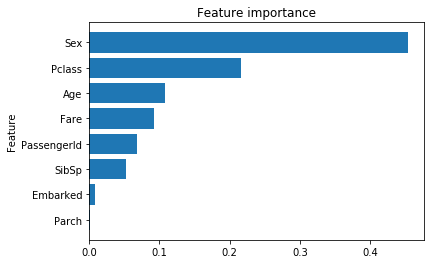

In [255]:
features = ["Passengerld","Pclass","Sex","Age",'SibSp',"Parch","Fare","Embarked"]
importances = GBC_model_test.feature_importances_
idx = np.argsort(importances)
plt.title("Feature importance")
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.ylabel("Feature")
plt.show()

### 3.3 Feature Engineering
Revisit the features in your dataset.
* Are each of the features being appropriately included in the analysis? 
* Find a way to engineer meaningful features from the "Name" and/or "Cabin" fields in the data.
* Create a final table that summarizes the performance of your models as follows:

| Model | Cross-validated Performance   | Test Performance | 
|------|------|------|
|   Decision Tree        |  |  |
|   Decision Tree (with imputed missing values and new features)        |  |  |
|   SVM  |  |  |
|   SVM (with imputed missing values and new features)        |  |  |
|   Random Forest        |  |  |
|   Random Forest (with imputed missing values and new features)        |  |  |
|   Gradient Boosting    |  |  | 
|   Gradient Boosting (with imputed missing values and new features)        |  |   x |


In [271]:
Final_Table = pd.DataFrame()
Models = ['Decision Tree','Decision Tree (with imputed missing values and new features','SVM','SVM (with imputed missing values and new features','Random Forest','Random Forest (with imputed missing values and new features','Gradient Boosting','Gradient Boosting with imputed missing values and new features']
CV_Performance = [max_test,mean_tree_cv_accuracy,svm_test_accuacy_2[max_C_idx],mean_svm_cv_accuracy,rf_CV_accuracy[max_indx_rf],imp_rf_mean_CV_accuracy,GBC_CV_accuracy[max_indx_GBC],imp_GBC_mean_CV_accuracy]
Test_Performance = [decision_tree_accuracy,tree_test_accuracy,svm_model_test_accuracy,svm_test_accuracy,rf_test_accuracy,imp_rf_test_accuracy,GBC_test_accuracy,imp_GBC_test_accuracy]

Final_Table['Model'] = Models
Final_Table['Cross-validated Performance'] = CV_Performance
Final_Table['Test Performance']=Test_Performance

Final_Table


,Model,Cross-validated Performance,Test Performance
0,Decision Tree,0.806579,0.755245
1,Decision Tree (with imputed missing values and...,0.811933,0.837989
2,SVM,0.662531,0.573427
3,SVM (with imputed missing values and new features,0.602602,0.608939
4,Random Forest,0.811967,0.783217
5,Random Forest (with imputed missing values and...,0.792701,0.849162
6,Gradient Boosting,0.822556,0.825175
7,Gradient Boosting with imputed missing values ...,0.818954,0.837989


* Are each of the features being appropriately included in the analysis? 

Each of the features are being appropriately included in the analysis. The features that aren't being included are the features that we got rid of, which were 'Name','Ticket', and 'Cabin'.

* Find a way to engineer meaningful features from the "Name" and/or "Cabin" fields in the data.

To engineer meaningful features from the Cabin column, we use a form of encoding. To do this, we see the letters for the cabin range from A,B,C,D,E and F. For example, we could treat A as 1, B as 2, C as 3, D as 4, E as 5, F as 6, and we replace 0 for all nan values. This is shown in the code below

* Create a final table that summarizes the performance of your models as follows:

The table above summarizes the performance of our models

In [292]:
pd.isnull(data.iloc[0,10])

True

In [295]:
# Encode features for the Cabin column, the cabin column is the 10th column

data = pd.read_csv("train.csv")

for i in range(len(data)): # iterate over observations
    if pd.isnull(data.iloc[i,10]): # If it is a null value, we replace it with 0.
        data.iloc[i,10] = 0
    else:
        if 'A' in data.iloc[i,10]: 
            data.iloc[i,10] = 1
        elif 'B' in data.iloc[i,10]: 
            data.iloc[i,10] = 2
        elif 'C' in data.iloc[i,10]: 
            data.iloc[i,10] = 3
        elif 'D' in data.iloc[i,10]: 
            data.iloc[i,10] = 4
        elif 'E' in data.iloc[i,10]: 
            data.iloc[i,10] = 5
        elif 'F' in data.iloc[i,10]: 
            data.iloc[i,10] = 6
            
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,3,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,3,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,0,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,2,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,0,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,3,C


## Part 4 (extra credit): Neural Networks

###  Let's get familiar with neural networks!
Now, try to predict survival on the Titanic using feed forward neural networks. This will likely be easiest with [TensorFlow](https://www.tensorflow.org/), as highlighted in the lab section.

For this problem, you are responsible for choosing the number of layers, their corresponding size, the activation functions, and the choice of gradient descent algorithm (and its parameters e.g. learning rate). Pick those parameters by hand. For some of them you can also perform cross-validation if you wish. Your goal is to tune those parameters so that your test accuracy is higher than 78%. Make sure you process your data appropriately before training your networks.

* Report your best accuracy on the test set along with your choice of parameters. More specifically, report the number of layers, their size, the activation functions and your choice of optimization algorithm. 

* Provide a plot of the test accuracy (y-axis) with respect to the number of epochs (x-axis). The number of epochs is the number of times we have iterated through our entire training set.

* It is a good exercise to experiment with different optimizers (gradient descent, stochastic gradient descent, AdaGrad etc), learning rates and batch sizes to get a feeling of how they affect neural network training. No need to report anything here. 


In [ ]:
# Enter your code here
import tensorflow as tf